In [1]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import expit
from collections import defaultdict
%load_ext autoreload
%autoreload 2

## Load the training data into feature matrix, class labels, and event ids:

In [ ]:
from proj1_helpers import *
from toolbox import *

DATA_TRAIN_PATH = 'train.csv' # path to train set
DATA_TEST_PATH = 'test.csv'   # path to test set
OUTPUT_PATH = 'out.csv'       # path to output

init_train_y, init_train_x, ids_train = load_csv_data(DATA_TRAIN_PATH, sub_sample=False)
_, init_test_x, ids_test = load_csv_data(DATA_TEST_PATH)

init_train_y = (init_train_y + 1.0) * 0.5

## Utility methods
When you add your own methods, please add a short description so that we all know what it does

In [192]:
def cropped_of_rows_with_999_value(x, y):
    """Returns updated x and y such that all row which contained
       at least one value = -999 are removed"""
    for i in range(x.shape[1]):
        idxes = (x[:, i] != -999)
        x = x[idxes]
        y = y[idxes]
    return x, y

def columns_with_999_value(x):
    """Returns the indices of all the columns which have at least one element = -999"""
    indexes = []
    for i in range(x.shape[1]):
        if np.any(x[:, i] == -999):
            indexes.append(i)
    return indexes

def column_mean_without_999(col):
    """Returns the mean of the vector without taking into account values = -999"""
    return np.mean(col[col[:] != -999])

def replace_999_with(col, val):
    """Replaces every element = -999 with the given value"""
    col[col[:] == -999] = val

def columns_with_low_corr(x, y):
    """Returns the indices of the columns which have a 
       'low' correlation to the output. (Experimental)"""
    indexes = []
    for i in range(x.shape[1]):
        if np.abs(np.corrcoef(x[:, i], y)[0][1]) < 0.03:
            indexes.append(i)
    return indexes

def cropped_of_columns(x, columns_indexes):
    """Returns a copy of x where the columns indexed by columns_indices are removed"""
    return np.delete(x, columns_indexes, axis = 1)

def get_999_indices_tuples(x):
    indices = defaultdict(lambda: [], {})
    for i in range(x.shape[0]):
        indices[tuple(x[i] == -999)].append(i)
    return indices

def augment(x, n):
    """Returns x concatenated with x ** 2, ..., x ** n"""
    return x if n == 1 else np.append(augment(x, n - 1), x ** n, axis = 1)

## Phase definitions

In [277]:
class BasePhase(object):
    """Base class for phases"""
    def __init__(self, next_phase):
        self.next_phase = next_phase

class InitPhase(BasePhase):
    """Copies the train and test set before executing next phase"""
    def run(self, init_train_x, init_train_y, init_test_x = None):
        train_x, train_y = np.copy(init_train_x), np.copy(init_train_y)
        test_x = None if init_test_x == None else np.copy(init_test_x)
        
        return self._run_next(train_x, train_y, test_x)

class StandardizePhase(BasePhase):
    """Standardize the dataset"""
    def run(self, train_x, train_y, test_x):
        train_x, mean, var = standardize(train_x)
        if test_x != None:
            test_x, _, _ = standardize(test_x, mean, var)
        
        return self._run_next(train_x, train_y, test_x)

class AugmentPhase(BasePhase):
    """Augments the dataset to the given degree n"""
    def __init__(self, n, next_phase):
        BasePhase.__init__(self, next_phase)
        self.n = n
        
    def run(self, train_x, train_y, test_x):
        train_x = augment(train_x, self.n)
        if test_x != None:
            test_x = augment(test_x, self.n)
        
        return self._run_next(train_x, train_y, test_x)

class Replace999ByColumnMeanPhase(BasePhase):
    """Replaces cells = -999 with their respective column's mean"""
    def run(self, train_x, train_y, test_x):
        for i in range(train_x.shape[1]):
            col = train_x[:, i]
            mean = column_mean_without_999(col)
            replace_999_with(col, mean)
            if test_x != None:
                col = test_x[:, i]
                mean = column_mean_without_999(col)
                replace_999_with(col, mean)

        return self._run_next(train_x, train_y, test_x)

class PlotFeatureOutputCorrelationPhase(BasePhase):
    """Plots feature to output correlation chart graph"""
    def run(self, train_x, train_y, test_x):
        feature_count = train_x.shape[1]

        corrs = np.zeros(feature_count)
        for i in range(feature_count):
            feature = train_x[:, i]
            corrs[i] = np.corrcoef(feature, train_y)[0][1]

        fig, ax = plt.subplots()

        ax.bar(np.arange(feature_count), corrs)
        
        return self._run_next(train_x, train_y, test_x)
        
class PlotGramMatrixPhase(BasePhase):
    """Plots the Gram matrix"""
    def run(self, train_x, train_y, test_x):
        G = train_x.T @ train_x
        plt.matshow(G, cmap = plt.cm.gray)
        
        return self._run_next(train_x, train_y, test_x)
    
class TrainPredictorPhase(BasePhase):
    """Trains a predictor with the given train set"""
    def __init__(self, gamma, max_iters, cross_validate, next_phase):
        BasePhase.__init__(self, next_phase)
        self.gamma = gamma
        self.max_iters = max_iters
        self.cross_validate = cross_validate
        
    def _build_k_indices(self, y, k_fold, seed):
        """build k indices for k-fold."""
        num_row = y.shape[0]
        interval = int(num_row / k_fold)
        np.random.seed(seed)
        indices = np.random.permutation(num_row)
        k_indices = [indices[k * interval: (k + 1) * interval] for k in range(k_fold)]
        return np.array(k_indices)

    def _cross_validation(self, y, tx, k_indices, k):
        """return the loss of ridge regression."""
        tmp_y = np.delete(y[k_indices], k, 0)
        tmp_x = np.delete(tx[k_indices], k, 0)
        train_y = tmp_y.reshape(tmp_y.shape[0] * tmp_y.shape[1])
        train_x = tmp_x.reshape((tmp_x.shape[0] * tmp_x.shape[1], tmp_x.shape[2]))
        test_y  = y[k_indices[k]]
        test_x  = tx[k_indices[k]]

        loss, w = logistic_regression(train_y, train_x, np.zeros(train_x.shape[1]), self.gamma, self.max_iters)

        train_y_pred = predict(train_x, w)
        test_y_pred  = predict(test_x,  w)

        train_y_err = np.count_nonzero(train_y_pred == train_y) / len(train_y)
        test_y_err  = np.count_nonzero(test_y_pred  == test_y ) / len(test_y)

        return train_y_err, test_y_err

    def run(self, train_x, train_y, test_x):
        if self.cross_validate:
            k_fold = 4
            k_indices = self._build_k_indices(y, k_fold, 1)
            print("Cross Validation:")
            for k in range(k_fold):
                train_err, test_err = self._cross_validation(train_y, train_x, k_indices, k)
                print("#%s fold: (Train error: %s, Test error: %s)" % (k, train_err, test_err))

        loss, w = logistic_regression(train_y, train_x, np.zeros(train_x.shape[1]), self.gamma, self.max_iters)
        pred = Predictor(w)
        
        return self._run_next(pred, train_x, train_y, test_x)

class Predictor(object):
    def __init__(self, w):
        self.w = w
    
    def predict(self, x):
        y_pred = expit(x @ self.w)

        y_pred[y_pred <  0.5] = 0
        y_pred[y_pred >= 0.5] = 1

        return y_pred

## Pipeline definition

C:\Users\Romain\Anaconda3\lib\site-packages\ipykernel\__main__.py:13: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
C:\Users\Romain\Anaconda3\lib\site-packages\ipykernel\__main__.py:46: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
C:\Users\Romain\Anaconda3\lib\site-packages\ipykernel\__main__.py:34: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
C:\Users\Romain\Anaconda3\lib\site-packages\ipykernel\__main__.py:21: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


MemoryError: 

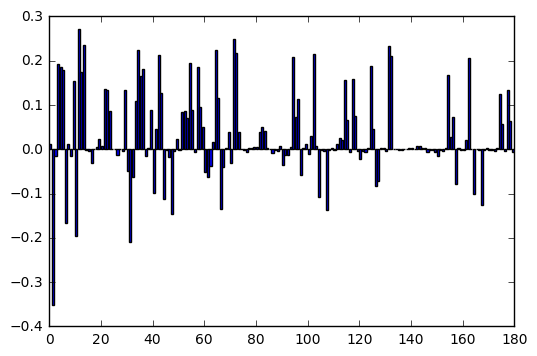

In [284]:
# Try your own transformations here

# IF YOU DO TRANSFORMATIONS WHICH AFFECT THE SHAPE OF X, DON'T FORGET TO
# MAKE THE SAME TRANSFORMATIONS ON X_TEST AT THE END

#rem_indices_1 = columns_with_999_value(init_x)
#rem_indices_1.remove(0)
#x = cropped_of_columns(init_x, rem_indices_1)

#print(rem_indices_1)

#rem_indices_2 = columns_with_low_corr(x, y) # []

#x, y = np.copy(init_x), init_y

#counts = defaultdict(lambda: [0, 0], {})
#for i in range(x.shape[0]):
#    counts[tuple(x[i] == -999)][int(y[i])] += 1
#for key, val in counts.items():
#    print(np.where(key), " : ", val)

#prdct = []
#for col_indices, row_indices in get_999_indices_tuples(x).items():
#    nx = np.delete(x[row_indices], np.where(col_indices), axis = 1)
#    prdct.append(Predictor(augment(nx, 6), y[row_indices])
    
#x, y = cropped_of_rows_with_999_value(init_x, init_y)
#x = augment(x, 6)

pipeline = InitPhase(
    Replace999ByColumnMeanPhase(
        AugmentPhase(6, 
            PlotFeatureOutputCorrelationPhase(
                StandardizePhase(
                    TrainPredictorPhase(0.6, 70000, False, 
                        None))))))

pred, train_x, train_y, test_x = pipeline.run(init_train_x, init_train_y, init_test_x)

print(train_x.shape, train_y.shape, test_x.shape)

## Test predictions against train set output

In [280]:
y_pred_train = pred.predict(train_x)

np.count_nonzero(y_pred_train == train_y) / len(train_y)

0.8111

## Generate predictions and save ouput in csv format for submission:

In [281]:
#test_counts = defaultdict(lambda: 0, {})

#for i in range(x_test.shape[0]):
#    test_counts[tuple(x_test[i] == -999)] += 1

#for key, val in test_counts.items():
#    print(np.where(key), " : ", val)

#tx_test, _, _ = standardize(x_test, mean, var)

#print(tx_test.shape)

In [283]:
y_pred_test = pred.predict(test_x)

create_csv_submission(ids_test, y_pred_test, OUTPUT_PATH)